In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('data/hour.csv', encoding='cp949')

# hour to sine frequency
df['hour_cos'] = np.cos(2*np.pi*df['hr']/24)
df['hour_sin'] = np.sin(2*np.pi*df['hr']/24)

# Data Split
val_split = 0.2
test_split = 0.1

train_df, val_df, test_df = np.split(df, [int((1-test_split-val_split)*len(df)), int((1-test_split)*len(df))])

In [2]:
# Category encoding - Exapanding Mean
cat_enc = dict()
for i in ['season', 'weathersit']:
    cumsum = train_df.groupby(i)['cnt'].cumsum() - train_df['cnt']
    cumcnt = train_df.groupby(i).cumcount() + 1

    # fit & tranform train data
    encoder_df = pd.DataFrame(np.array([train_df[i], cumsum / cumcnt]).T, columns=[i, 'encoding'])
    train_df[i] = encoder_df['encoding']

    # transform valid, test data
    encoder = encoder_df.groupby(i).mean().to_dict('dict')
    cat_enc[i] = encoder # save encoder
    val_df[i] = val_df[i].map(encoder['encoding'])
    test_df[i] = test_df[i].map(encoder['encoding'])

In [3]:
# target : cnt
from sklearn.preprocessing import PowerTransformer
tfm = PowerTransformer()
train_df['cnt_tfm'] = tfm.fit_transform(train_df[['cnt']])
val_df['cnt_tfm'] = tfm.transform(val_df[['cnt']])
test_df['cnt_tfm'] = tfm.transform(test_df[['cnt']])

In [4]:
features = ['hour_cos', 'hour_sin', 'season', 'holiday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt_tfm']

target = ['cnt']

to_scale = ['season', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_df[to_scale] = scaler.fit_transform(train_df[to_scale])
val_df[to_scale] = scaler.transform(val_df[to_scale])
test_df[to_scale] = scaler.transform(test_df[to_scale])

In [5]:
# window data
def window(sequence, n_lookback, n_pred):
    sequence = np.float32(sequence)
    X, y = list(), list()
    for i in range(len(sequence)):
        end_idx = i + n_lookback
        out_end_idx = end_idx + n_pred
        if out_end_idx > len(sequence):
            break
        X.append(sequence[i:end_idx,:-1])
        y.append(sequence[end_idx:out_end_idx, -1])

    X, y = np.array(X), np.array(y)
    if n_pred == 1:
        y = y.reshape(-1,1)

    return X, y

import tensorflow as tf

# to tensorflow dataset
def to_dataset(data, n_lookback, n_pred, batch_size, isTrain):
    X, y = window(data, n_lookback, n_pred)
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    if isTrain:
        dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    else:
        dataset = dataset.batch(batch_size)

    return dataset

train_ds = train_df[features+target]
val_ds = val_df[features+target]
test_ds = test_df[features+target]

# set data steps
n_features = len(features)
n_lookback = 24
n_pred = 6
batch_size = 256

train_ds = to_dataset(train_ds, n_lookback, n_pred, batch_size, True)
val_ds = to_dataset(val_ds, n_lookback, n_pred, batch_size, False)
test_ds = to_dataset(test_ds, n_lookback, n_pred, batch_size, False)

tf.data.experimental.save(test_ds, 'test_data')

In [ ]:
# Create simple LSTM Model
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, optimizers, losses, metrics, activations

def CreateModel():
    inputs = layers.Input(shape=(n_lookback, n_features))
    x = layers.LSTM(units = 150, return_sequences = False, activation= tf.nn.tanh, dropout=0.2)(inputs)
    outputs = layers.Dense(n_pred)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizers.Adam(), loss=losses.MeanSquaredError(), metrics = [metrics.RootMeanSquaredError(name='metric')])

    return model

model = CreateModel()

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, verbose=0, mode='min')
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20)

model.fit(train_ds, validation_data=val_ds, epochs=300, callbacks=[earlystop], verbose=1)

# to concrete function
run_model = tf.function(lambda x: model(x))
# Fix the input size - use in inference
infer_size = 1
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([infer_size, n_lookback, n_features], model.inputs[0].dtype))

model.save('LSTM', save_format="tf", signatures=concrete_func)

In [7]:
# inverse scaling - only target variable
def inverse_transform(x):
    array = np.concatenate((np.zeros((len(x), scaler.n_features_in_-1)), x.reshape(-1,1)), axis=1)
    array_transform = scaler.inverse_transform(array)[:,-1] # last window step

    return array_transform

# stack inverse transformed array
def get_inv(array):
    return np.stack([inverse_transform(array[:,i]) for i in range(n_pred)], axis=-1)

X_test = np.concatenate([f for f, _ in test_ds])
y_test = np.concatenate([t for _, t in test_ds])

y_pred = model.predict(X_test)

y_pred = get_inv(y_pred)
y_test = get_inv(y_test)

In [8]:
def metric(pred_idx = 'all'):
    if pred_idx in ['all']:
        _y_test = y_test
        _y_pred = y_pred
    else:
        _y_test = y_test[:,pred_idx]
        _y_pred = y_pred[:,pred_idx]

    # regression evaluate
    metrics = dict()
    from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error, r2_score
    metrics['rmse'] = np.sqrt(mean_squared_error(_y_test, _y_pred))
    metrics['mae'] = mean_absolute_error(_y_test, _y_pred)
    metrics['mape'] = mean_absolute_percentage_error(_y_test, _y_pred)
    # metrics['msle'] = mean_squared_log_error(true, mean)
    metrics['r2'] = r2_score(_y_test, _y_pred)

    metric_df = pd.DataFrame(list(metrics.items()), columns=['metric', 'value'])

    print(metric_df)
    
    return metric_df

def pred_plot(pred_idx):
    plt.figure(figsize=(30,6))
    plt.plot(y_test[:,pred_idx], label = 'y_true')
    plt.plot(y_pred[:,pred_idx], label = 'y_pred')
    plt.legend()
    plt.show()
    

In [9]:
metric_df = metric(pred_idx ='all')

  metric      value
0   rmse  88.592827
1    mae  57.482423
2   mape   0.915986
3     r2   0.779046


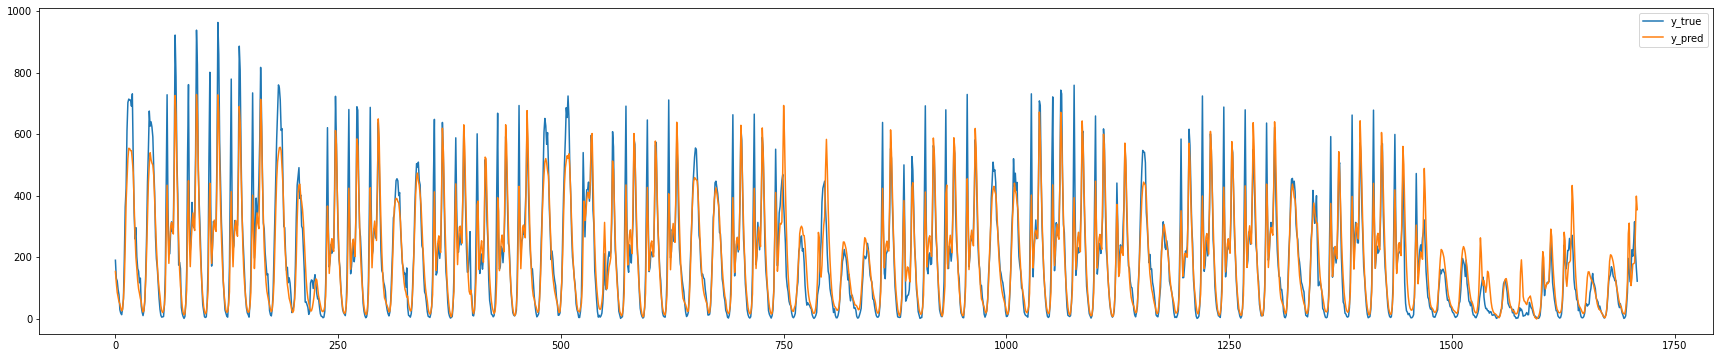

In [10]:
pred_plot(pred_idx=0)

In [11]:
import tensorflow_model_optimization as tfmot

# Dynamic Quantiztion
def Dynamic():
    converter = tf.lite.TFLiteConverter.from_saved_model('LSTM')
    converter.optimizations = []
    lite_model = converter.convert()

    with open('lite/dynamic.tflite', 'wb') as f:
        f.write(lite_model)

    return lite_model

# Quantiztion Dense layer
def apply_quantization_to_dense(layer):
    if isinstance(layer, layers.Dense):
        return tfmot.quantization.keras.quantize_annotate_layer(layer)
    return layer

# Qauntim Aware Training
def QAT():
    model = models.load_model('LSTM')

    annotated_model = models.clone_model(
        model,
        clone_function=apply_quantization_to_dense,
    )

    qat_model = tfmot.quantization.keras.quantize_apply(annotated_model)
    converter = tf.lite.TFLiteConverter.from_keras_model(qat_model)
    # converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.optimizations = []
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
        tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
        ]
    converter._experimental_lower_tensor_list_ops = False
    
    lite_model = converter.convert()

    with open('lite/qat.tflite', 'wb') as f:
        f.write(lite_model)

    return lite_model

def apply_pruning_to_dense(layer):
    if isinstance(layer, layers.Dense):
        return tfmot.sparsity.keras.prune_low_magnitude(layer)
    return layer

# Pruning
def Pruning():
    model = models.load_model('LSTM')
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                                final_sparsity=0.80,
                                                                begin_step=0,
                                                                end_step=100)
        }
    
    pruning_model = models.clone_model(model, clone_function=apply_pruning_to_dense)
    pruning_model = prune_low_magnitude(model, **pruning_params)
    pruning_model.compile(loss=losses.MeanSquaredError(), optimizer=optimizers.Adam())

    callbacks = [
        earlystop,
        tfmot.sparsity.keras.UpdatePruningStep(),
        # tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
        ]
    
    # re-training pruned model
    pruning_model.fit(train_ds, epochs=300, batch_size = 256, validation_data=val_ds,callbacks=callbacks, verbose=0)
    model_for_export = tfmot.sparsity.keras.strip_pruning(pruning_model)
    converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
    converter.optimizations = []
    converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
    ]
    lite_model = converter.convert()

    with open('lite/pruning.tflite', 'wb') as f:
        f.write(lite_model)

    return lite_model

# set cluster weights
cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization
clustering_params = {
    'number_of_clusters': 4,
    'cluster_centroids_init': CentroidInitialization.DENSITY_BASED
    }

def apply_clustering_to_dense(layer):
    if isinstance(layer, layers.Dense):
        return cluster_weights(layer, **clustering_params)
    return layer

# cluster
def Cluster():
    model = models.load_model('LSTM')

    clustered_model = models.clone_model(model, clone_function=apply_clustering_to_dense)

    clustered_model.compile(loss=losses.MeanSquaredError(),optimizer=optimizers.Adam())

    # re-train clustered model
    callbacks = [earlystop]
    clustered_model.fit(train_ds, epochs=300, batch_size = 256, validation_data=val_ds,callbacks=callbacks, verbose=0)

    final_model = tfmot.clustering.keras.strip_clustering(clustered_model)
    converter = tf.lite.TFLiteConverter.from_keras_model(final_model)
    converter.optimizations = []
    converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
    ]
    lite_model = converter.convert()
    
    with open('lite/cluster.tflite', 'wb') as f:
        f.write(lite_model)

    return lite_model


In [12]:
dynamic = Dynamic()
qat = QAT()
pruning = Pruning()
cluster = Cluster()

Estimated count of arithmetic ops: 0.226 M  ops, equivalently 0.113 M  MACs


2022-07-15 03:09:04.833945: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-07-15 03:09:04.833967: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-07-15 03:09:04.834428: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: LSTM
2022-07-15 03:09:04.838034: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-07-15 03:09:04.838045: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: LSTM
2022-07-15 03:09:04.848115: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-07-15 03:09:04.878419: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: LSTM
2022-07-15 03:09:04.894596: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 60169 microseconds.
2022-07-15 03:09:04.919

INFO:tensorflow:Assets written to: /tmp/tmpk96de2do/assets


INFO:tensorflow:Assets written to: /tmp/tmpk96de2do/assets


2022-07-15 03:09:07.443324: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-07-15 03:09:07.443347: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-07-15 03:09:07.443482: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpk96de2do
2022-07-15 03:09:07.446011: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-07-15 03:09:07.446023: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpk96de2do
2022-07-15 03:09:07.455384: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-07-15 03:09:07.475699: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpk96de2do
2022-07-15 03:09:07.489095: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 45614 m

INFO:tensorflow:Assets written to: /tmp/tmpf59dy2yc/assets


INFO:tensorflow:Assets written to: /tmp/tmpf59dy2yc/assets


2022-07-15 03:09:30.388956: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-07-15 03:09:30.388974: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-07-15 03:09:30.389109: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpf59dy2yc
2022-07-15 03:09:30.391632: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-07-15 03:09:30.391644: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpf59dy2yc
2022-07-15 03:09:30.401184: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-07-15 03:09:30.419118: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpf59dy2yc
2022-07-15 03:09:30.432266: I tensorflow/cc/saved_model/loader.cc:301] SavedModel load for tags { serve }; Status: success: OK. Took 43157 m

INFO:tensorflow:Assets written to: /tmp/tmpf72eapkx/assets


INFO:tensorflow:Assets written to: /tmp/tmpf72eapkx/assets
2022-07-15 03:09:52.558720: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-07-15 03:09:52.558744: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-07-15 03:09:52.558887: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpf72eapkx
2022-07-15 03:09:52.561399: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-07-15 03:09:52.561412: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpf72eapkx
2022-07-15 03:09:52.570790: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-07-15 03:09:52.588838: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpf72eapkx
2022-07-15 03:09:52.601633: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

In [13]:
X_test = np.concatenate([f for f, _ in test_ds])
y_test = np.concatenate([t for _, t in test_ds])

In [14]:
import time

# inference test
def Inference(path):
    inference_time = 0

    interpreter = tf.lite.Interpreter(model_path=path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    predict_tflite = []
    for t in range(len(X_test)):
        start_time=time.time()
        interpreter.set_tensor(input_details[0]["index"], X_test[t:t+infer_size])
        interpreter.invoke()

        # probability.
        output = interpreter.get_tensor(output_details[0]["index"])
        predict_tflite.append(output)

        inference_time += time.time()-start_time
    
    print(inference_time)
    predict_tflite = np.array(predict_tflite).reshape(y_pred.shape[0], y_pred.shape[1])

    return predict_tflite

In [15]:
Inference('lite/dynamic.tflite')

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


0.6176221370697021


array([[ 0.2052405 ,  0.11761957,  0.06081362,  0.03303793,  0.03362919,
        -0.00582953],
       [ 0.17551537,  0.09340947,  0.04608284,  0.02271383,  0.02220806,
        -0.01706832],
       [ 0.12731051,  0.05794878,  0.02619378,  0.01189286,  0.00978399,
        -0.0213465 ],
       ...,
       [ 0.30632314,  0.38577697,  0.47563118,  0.4315295 ,  0.3234912 ,
         0.16488716],
       [ 0.39048007,  0.49751252,  0.41407573,  0.26871622,  0.20868051,
         0.11263464],
       [ 0.47099003,  0.41394457,  0.25529787,  0.1679498 ,  0.14492539,
         0.07773221]], dtype=float32)